# Use tensorflow object detection API


In [1]:
!git clone https://github.com/tensorflow/models.git
!apt-get -qq install libprotobuf-java protobuf-compiler
!protoc ./models/research/object_detection/protos/string_int_label_map.proto --python_out=.
!cp -R models/research/object_detection/ object_detection/
!rm -rf models

Cloning into 'models'...
remote: Enumerating objects: 66837, done.
remote: Total 66837 (delta 0), reused 0 (delta 0), pack-reused 66837
Receiving objects: 100% (66837/66837), 575.97 MiB | 29.20 MiB/s, done.
Resolving deltas: 100% (46829/46829), done.


## Import packets

In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt

from PIL import Image

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Set environment and path

In [5]:
# Set the name of the model to be used (there are different model candidates)
# MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2017_11_08'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Model path
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

# import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()

# This file holds the categories corresponding to the different boxes
PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')

# Total 90 classes
NUM_CLASSES = 90

opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)   # Retrieve model 
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())   # extract tar file
    
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.compat.v1.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)    # Load label map
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)    # Extract categories
category_index = label_map_util.create_category_index(categories)   # Set index related categories

In [6]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

## Set the test set environment
Set the path of the test image dataset to be detected

In [7]:
# image1.jpg
# image2.jpg
PATH_TO_TEST_IMAGES_DIR = 'object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Set the size of the output image
IMAGE_SIZE = (12, 8)

## Object detection
The actual process of executing and performing image object detection in a TF session

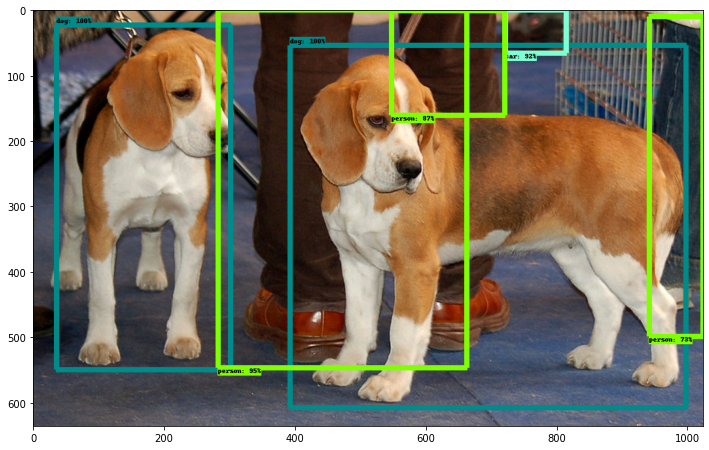

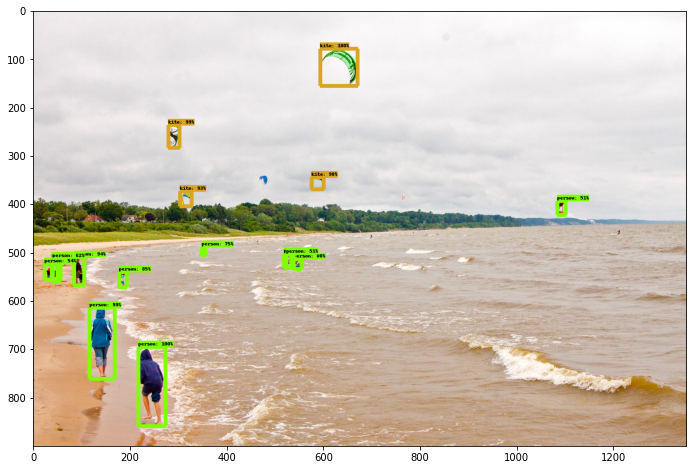

In [8]:
%matplotlib inline 

with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    # Definite input and output Tensors for detection_graph
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    # Each box represents a part of the image where a particular object was detected.
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      # The array based representation of the image will be used later in order to prepare the
      # Result image with boxes and labels on it.
      image_np = load_image_into_numpy_array(image)
      # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
      image_np_expanded = np.expand_dims(image_np, axis=0)
      # Actual detection.
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      # Visualization of the results of a detection.
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)

## Testing of own dataset

In [9]:
!mkdir images

In [10]:
!wget http://farm6.staticflickr.com/5485/9424913933_2d24e654ac_z.jpg -O images/custom_img_2.jpg

--2021-11-14 11:29:20--  http://farm6.staticflickr.com/5485/9424913933_2d24e654ac_z.jpg
Resolving farm6.staticflickr.com (farm6.staticflickr.com)... 52.84.182.78, 2600:9000:20be:e00:0:5a51:64c9:c681, 2600:9000:20be:ca00:0:5a51:64c9:c681, ...
Connecting to farm6.staticflickr.com (farm6.staticflickr.com)|52.84.182.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm6.staticflickr.com/5485/9424913933_2d24e654ac_z.jpg [following]
--2021-11-14 11:29:20--  https://farm6.staticflickr.com/5485/9424913933_2d24e654ac_z.jpg
Connecting to farm6.staticflickr.com (farm6.staticflickr.com)|52.84.182.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘images/custom_img_2.jpg’

images/custom_img_2     [ <=>                ] 157.06K  --.-KB/s    in 0.01s   

2021-11-14 11:29:20 (11.7 MB/s) - ‘images/custom_img_2.jpg’ saved [160834]



In [11]:
!wget http://farm4.staticflickr.com/3674/9412766091_03a2e22443_z.jpg -O images/custom_img_1.jpg

--2021-11-14 11:29:24--  http://farm4.staticflickr.com/3674/9412766091_03a2e22443_z.jpg
Resolving farm4.staticflickr.com (farm4.staticflickr.com)... 52.84.182.78, 2600:9000:20be:de00:0:5a51:64c9:c681, 2600:9000:20be:a800:0:5a51:64c9:c681, ...
Connecting to farm4.staticflickr.com (farm4.staticflickr.com)|52.84.182.78|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://farm4.staticflickr.com/3674/9412766091_03a2e22443_z.jpg [following]
--2021-11-14 11:29:24--  https://farm4.staticflickr.com/3674/9412766091_03a2e22443_z.jpg
Connecting to farm4.staticflickr.com (farm4.staticflickr.com)|52.84.182.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘images/custom_img_1.jpg’

images/custom_img_1     [ <=>                ] 147.54K  --.-KB/s    in 0.02s   

2021-11-14 11:29:25 (8.52 MB/s) - ‘images/custom_img_1.jpg’ saved [151081]



In [12]:
!ls ./images/ | head -10

custom_img_1.jpg
custom_img_2.jpg


In [13]:
PATH_TO_TEST_IMAGES_DIR = 'images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'custom_img_{}.jpg'.format(i)) for i in range(1, 3) ]

IMAGE_SIZE = (12, 8)

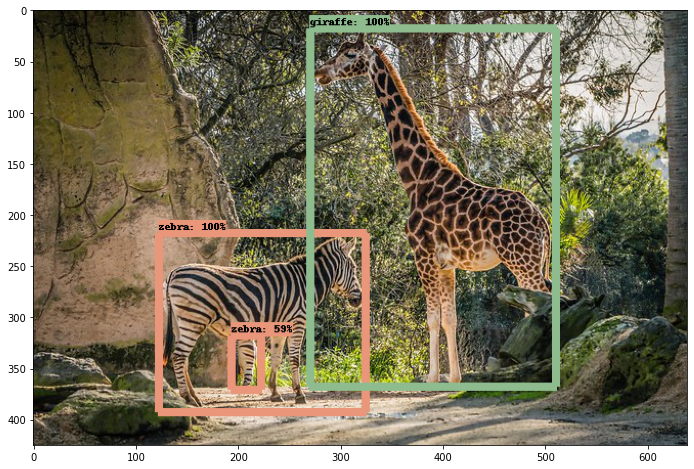

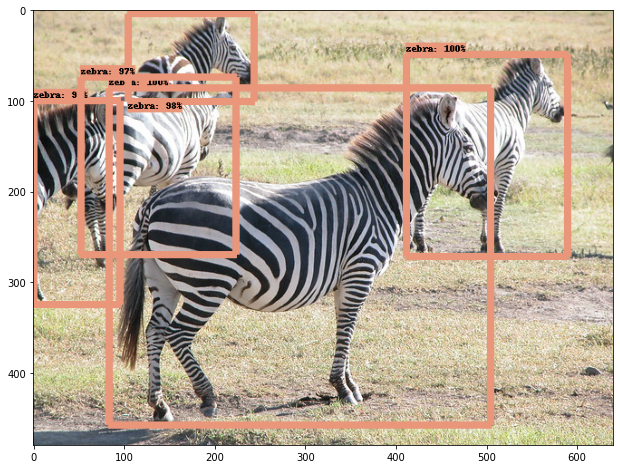

In [14]:
with detection_graph.as_default():
  with tf.Session(graph=detection_graph) as sess:
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
    detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
    detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
    detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')
    for image_path in TEST_IMAGE_PATHS:
      image = Image.open(image_path)
      image_np = load_image_into_numpy_array(image)
      image_np_expanded = np.expand_dims(image_np, axis=0)
      (boxes, scores, classes, num) = sess.run(
          [detection_boxes, detection_scores, detection_classes, num_detections],
          feed_dict={image_tensor: image_np_expanded})
      vis_util.visualize_boxes_and_labels_on_image_array(
          image_np,
          np.squeeze(boxes),
          np.squeeze(classes).astype(np.int32),
          np.squeeze(scores),
          category_index,
          use_normalized_coordinates=True,
          line_thickness=8)
      plt.figure(figsize=IMAGE_SIZE)
      plt.imshow(image_np)